In [1]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn import datasets

import sys
!{sys.executable} -m pip install PyAthena
from pyathena import connect
import pandas as pd
from pyathena.async_cursor import AsyncCursor

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly

import boto3

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
def q2df(q):
    cursor = connect(s3_staging_dir='s3://esdis-ems-athena', region_name='us-west-2', cursor_class=AsyncCursor).cursor(max_workers=2)
    query_id, future = cursor.execute(q)
    print (query_id, future)
#i=0
#for row in cursor:
#    if i==0:
#        print(row)
#    i+=1
#pd.options.display.float_format = '{:,.4f}'.format
#df = pd.read_sql(q, conn)
#df
    result_set = future.result()
    print(result_set.state)
#    print(result_set.state_change_reason)
#    print(result_set.completion_date_time)
#    print(result_set.submission_date_time)
    print('Data Scanned Bytes:', result_set.data_scanned_in_bytes)
#    print(result_set.engine_execution_time_in_millis)
#    print(result_set.query_queue_time_in_millis)
    print('Total Execution Time (ms):', result_set.total_execution_time_in_millis)
#    print(result_set.query_planning_time_in_millis)
#    print(result_set.service_processing_time_in_millis)
    print('Output location:', result_set.output_location)
    print(result_set.description)


    s3_client = boto3.client('s3')

    obj=result_set.output_location[result_set.output_location.rfind('/')+1:]
    print(obj)

    s3_client.download_file('esdis-ems-athena', obj, 'myOut.csv')

    df=pd.read_csv('myOut.csv')  
    return df

In [3]:
conn = connect(s3_staging_dir='s3://esdis-ems-athena', region_name='us-west-2')
cursor=conn.cursor()

In [32]:
q="""
with t1 as
(select
 time,
 lon,
 lat,
 ts,
 var_ts,
 sqrt(var_ts) stdev_ts
from sci.merra2_2d_monthly
where 
  time between timestamp '2021-08-01' and timestamp '2021-08-31'
),
t2 as 
(select
 lon,
 lat,
 avg(TS) ts
from sci.merra_2d
where
 date_part between timestamp '2021-08-01' and timestamp '2021-08-31'
group by
 lon, lat
)
select
 t2.lon, 
 t2.lat, 
 t2.ts, 
 t1.ts ts_month_avg, 
 t1.var_ts,
 t2.ts - t1.ts ts_diff_avg
from t1, t2
where
-- year(t2.time) = year(t1.time)
-- and month(t2.time) = month(t2.time)
 t2.lon = t1.lon
 and t2.lat = t1.lat
 and (
   t2.ts < t1.ts - ( 3 * t1.stdev_ts) or t2.ts > t2.ts + ( 3 * t1.stdev_ts)
   )
order by
 t2.ts - t1.ts desc
"""
df = pd.read_sql(q, conn)

In [33]:
for i,r in df.iterrows():
    #print (i, r['time'], r['prectot_sum_local'], r['prectot_sum_global'])    
    print (i, r)
    break

In [31]:
import plotly.express as px

df['size']=10


# Normalize Color Scheme
minColor = min(df['ts_diff_avg'])
maxColor = max(df['ts_diff_avg'])

if abs(minColor) > abs(maxColor):
    maxColor = 0 + abs(minColor)
else:
    minColor = 0 - abs(maxColor)

print (minColor, maxColor)


fig = px.scatter_mapbox(
    df, 
    lat="lat", 
    lon="lon",
    mapbox_style="open-street-map",
    range_color=[minColor, maxColor],
    color="ts_diff_avg", 
    size="size",
#    color_continuous_scale='jet', 
    size_max=10, 
#    hover_name='time',
    #hover_data=['lon', 'lat', 'sum_so2_mol_lay', 'sat_name_part', 'obs_date_part'],
    title = 'TEst')
#fig.show()
fig.write_html('merra2_anomly_map.html')

ValueError: min() arg is an empty sequence

In [4]:
q="""
select
-- LWTUP,
 PRECTOT,
 TS
from
 sci.merra2_2d_monthly
where
 Month(time) = 6
limit 5000000
"""
#df = pd.read_sql(q, conn)
df=q2df(q)

474cf0d9-ac3d-4c66-a212-3a1c17d2502d <Future at 0x7f3d2a296e48 state=running>
SUCCEEDED
Data Scanned Bytes: 92320181
Total Execution Time (ms): 14705
Output location: s3://esdis-ems-athena/474cf0d9-ac3d-4c66-a212-3a1c17d2502d.csv
[('PRECTOT', 'float', None, None, 17, 0, 'UNKNOWN'), ('TS', 'float', None, None, 17, 0, 'UNKNOWN')]
474cf0d9-ac3d-4c66-a212-3a1c17d2502d.csv


In [6]:
#print (df)
#x=np.dstack((df.lon, df.lat, df.m_month, df.m_week, df.LWGEM, df.LWTUP, df.PRECTOT, df.TS))
#x=np.dstack((df.LWTUP, df.PRECTOT, df.TS))
x=np.dstack((df.PRECTOT, df.TS))

In [7]:
print (x.shape)

(1, 5000000, 2)


In [8]:
kmeans=KMeans(n_clusters=6)

In [9]:
kmeans.fit(x[0])

KMeans(n_clusters=6)

In [10]:
print (kmeans.cluster_centers_)
print (kmeans.labels_)
#print (x[0][:,[0]])

[[2.41318045e-05 2.74440264e+02]
 [1.61988392e-06 2.11703476e+02]
 [3.94368640e-05 2.99622617e+02]
 [3.36064907e-05 2.87085965e+02]
 [2.01666615e-05 2.57930083e+02]
 [6.76731784e-06 2.33606774e+02]]
[2 2 0 ... 2 3 1]


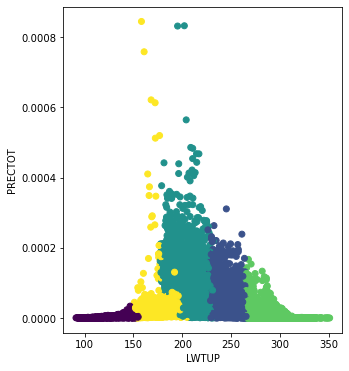

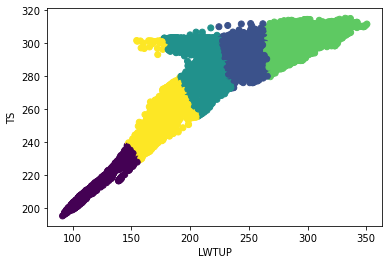

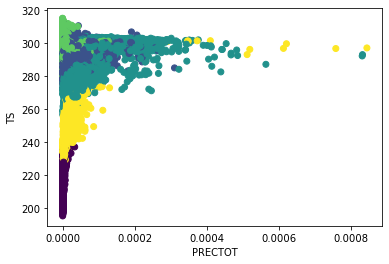

In [75]:
plt.figure(figsize=(5,6))
plt.scatter(x[0][:,[0]], x[0][:,[1]],c=kmeans.labels_)
plt.xlabel("LWTUP")
plt.ylabel("PRECTOT")
plt.show()
plt.scatter(x[0][:,[0]], x[0][:,[2]],c=kmeans.labels_)
plt.xlabel("LWTUP")
plt.ylabel("TS")
plt.show()
plt.scatter(x[0][:,[1]], x[0][:,[2]],c=kmeans.labels_)
plt.xlabel("PRECTOT")
plt.ylabel("TS")
plt.show()

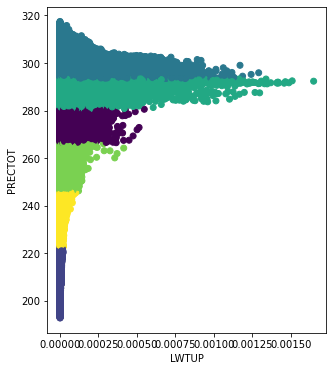

In [12]:
plt.figure(figsize=(5,6))
plt.scatter(x[0][:,[0]], x[0][:,[1]],c=kmeans.labels_)
plt.xlabel("LWTUP")
plt.ylabel("PRECTOT")
plt.show()
#plt.scatter(x[0][:,[0]], x[0][:,[2]],c=kmeans.labels_)
#plt.xlabel("LWTUP")
#plt.ylabel("TS")
#plt.show()
#plt.scatter(x[0][:,[1]], x[0][:,[2]],c=kmeans.labels_)
#plt.xlabel("PRECTOT")
#plt.ylabel("TS")
#plt.show()

est= [2 2 2 ... 0 0 3]


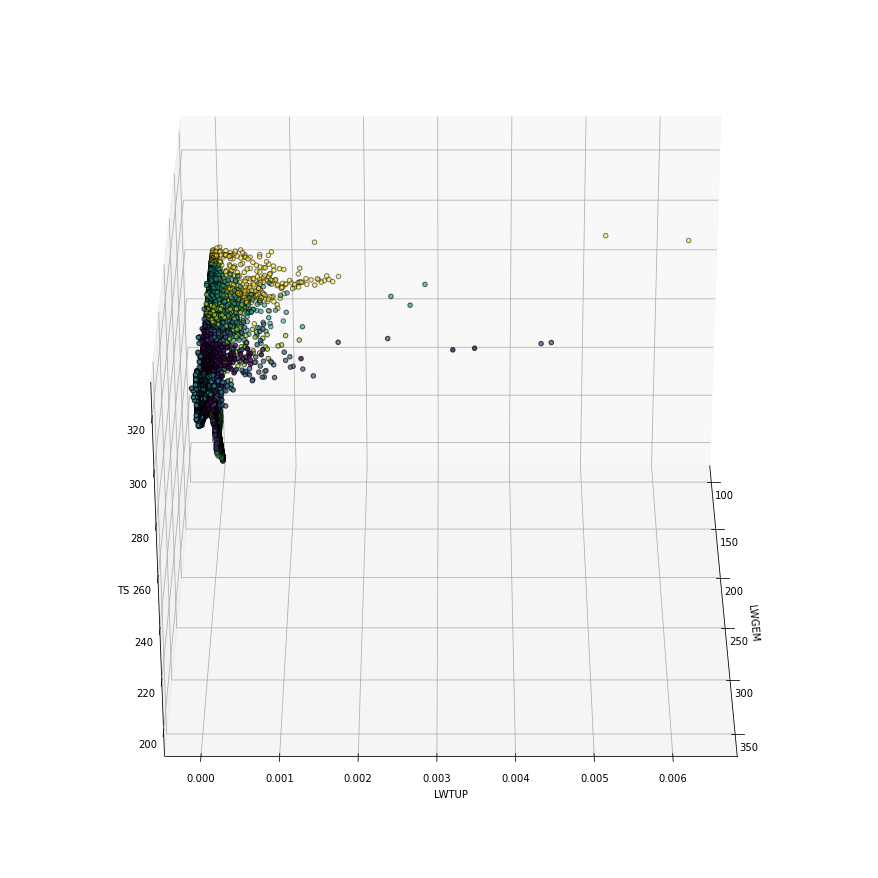

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
#%matplotlib notebook
#%matplotlib widget
%matplotlib inline
##matplotlib.use("agg")
fignum = 1
titles = ["8 clusters"]
estimators = [kmeans]
for est in estimators:
    fig = plt.figure(fignum, figsize=(16,12))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
    #est.fit(X)
    labels = est.labels_
    print ('est=', est.labels_)
    
    ax.scatter(x[0][:,[0]], x[0][:,[1]], x[0][:,[2]], c=est.labels_.astype(float), edgecolor="k")
#    ax.w_xaxis.set_ticklabels([])
#    ax.w_yaxis.set_ticklabels([])
#    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel("LWGEM")
    ax.set_ylabel("LWTUP")
    ax.set_zlabel("TS")
#    ax.set_title(titles[fignum - 1])
#    ax.dist = 12
#    fignum = fignum + 1

#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.1)